In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from sklearn.metrics import r2_score
from scipy.spatial import distance
from skbio.stats.ordination import pcoa
%run -i '../../utils.py'

# Get data

In [3]:
# read meta data
df_meta = pd.read_excel('../../our_data/meta_data.xlsx', index_col=0)
df_meta = df_meta[df_meta.Diet=='Inulin']
df_meta = df_meta.drop('Diet', axis=1)
df_meta = df_meta.rename({'MiceID':'SubjectID'}, axis=1)
df_meta.head()

,SubjectID,Vendor,Day,RandomizedGroup
SampleID,,,,
sample141,BI1,Beijing,0,A
sample142,BI2,Beijing,0,B
sample143,BI3,Beijing,0,D
sample144,BI4,Beijing,0,E
sample145,BI5,Beijing,0,C


In [4]:
# read SCFA data
df_scfa = pd.read_excel('../../our_data/SCFA.xlsx', index_col=0)
df_scfa.head()

,Acetate,Propionate,Butyrate
SampleID,,,
sample36,1.372492,0.463378,0.553858
sample86,2.019028,0.644090,0.757294
sample277,2.061243,1.140312,1.142147
sample116,2.066010,0.856857,0.582644
sample69,2.644383,0.955464,0.682562


In [17]:
# read bacterial abundance
df_bac_relab = pd.read_excel('../../our_data/16S_relative_abundance.xlsx', index_col=0)

# run PcoA
dist_relab = distance.squareform(distance.pdist(df_bac_relab, metric="braycurtis"))
df_dist_relab = pd.DataFrame(dist_relab, index = df_bac_relab.index, columns = df_bac_relab.index)
OrdinationResults = pcoa(df_dist_relab.values, number_of_dimensions=3)
df_ord_relab = pd.DataFrame(OrdinationResults.samples.values, index=df_bac_relab.index, columns=['PC1_relab','PC2_relab','PC3_relab'])
df_ord_relab.head()

,PC1_relab,PC2_relab,PC3_relab
SampleID,,,
sample131,0.148189,0.043239,-0.126116
sample132,0.040831,0.112277,-0.108926
sample133,0.119982,-0.043528,-0.111207
sample134,0.112015,0.127315,-0.015109
sample135,0.152046,-0.010801,-0.082458


In [18]:
# read bacterial abundance
df_bac_absab = pd.read_excel('../../our_data/16S_absolute_abundance.xlsx', index_col=0)

# run PcoA
dist_absab = distance.squareform(distance.pdist(df_bac_absab, metric="braycurtis"))
df_dist_absab = pd.DataFrame(dist_absab, index = df_bac_absab.index, columns = df_bac_absab.index)
OrdinationResults = pcoa(df_dist_absab.values, number_of_dimensions=3)
df_ord_absab = pd.DataFrame(OrdinationResults.samples.values, index=df_bac_absab.index, columns=['PC1_absab','PC2_absab','PC3_absab'])
df_ord_absab.head()

,PC1_absab,PC2_absab,PC3_absab
SampleID,,,
sample131,-0.050395,-0.237866,-0.207093
sample132,-0.000732,-0.194070,-0.070564
sample133,0.063309,-0.235264,-0.291864
sample134,-0.154697,-0.089413,0.029899
sample135,-0.030914,-0.237817,-0.263255


In [19]:
df_join = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_join = pd.merge(df_join, df_ord_relab, left_index=True, right_index=True, how='inner')
df_join = pd.merge(df_join, df_ord_absab, left_index=True, right_index=True, how='inner')
df_join.head()

,SubjectID,Vendor,Day,RandomizedGroup,Acetate,Propionate,Butyrate,PC1_relab,PC2_relab,PC3_relab,PC1_absab,PC2_absab,PC3_absab
SampleID,,,,,,,,,,,,,
sample141,BI1,Beijing,0,A,5.233899,1.930933,1.109582,0.164271,-0.109222,-0.165155,-0.023861,-0.211264,-0.301661
sample142,BI2,Beijing,0,B,13.459823,3.621771,1.546647,0.097579,0.023014,-0.138599,0.137525,-0.288046,-0.262716
sample143,BI3,Beijing,0,D,18.075378,2.859916,1.682656,0.165344,0.224611,0.076815,-0.131593,-0.238274,0.090002
sample144,BI4,Beijing,0,E,12.580368,3.148773,1.477688,0.117182,0.380281,-0.025986,-0.064181,-0.342961,0.187363
sample145,BI5,Beijing,0,C,8.065127,3.134209,1.835172,0.217290,0.103628,-0.114395,-0.176079,-0.186361,-0.056688


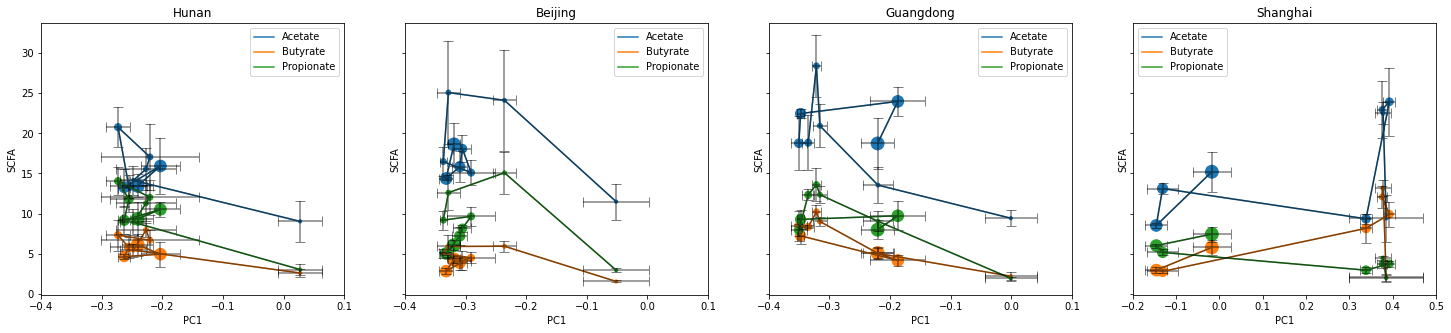

In [46]:
fig, ax = plt.subplots(figsize=(25,5), nrows=1, ncols=4, sharey=True)

for k,vendor in enumerate(['Hunan','Beijing','Guangdong','Shanghai']):
    df_join_tmp_mean = df_join[df_join.Vendor==vendor].sort_values(by='Day').groupby('Day').agg(np.mean).reset_index()
    df_join_tmp_sem = df_join[df_join.Vendor==vendor].sort_values(by='Day').groupby('Day').agg(scipy.stats.sem).reset_index()
    for scfa_ in ['Acetate','Butyrate','Propionate']:
        _ = ax[k].errorbar(df_join_tmp_mean['PC1_absab'], df_join_tmp_mean[scfa_], yerr=df_join_tmp_sem[scfa_], xerr=df_join_tmp_sem['PC1_absab'], color='k', capsize=5, alpha=0.5, linestyle=None)
        _ = ax[k].plot(df_join_tmp_mean['PC1_absab'], df_join_tmp_mean[scfa_], label=scfa_)
        _ = ax[k].scatter(df_join_tmp_mean['PC1_absab'], df_join_tmp_mean[scfa_], s=df_join_tmp_mean['Day']*5+10)
    ax[k].set_ylabel('SCFA')
    ax[k].set_xlabel('PC1')
    ax[k].set_title(vendor)
    ax[k].legend()
    if vendor=='Shanghai':
        ax[k].set_xlim([-0.2,0.5])
    else:
        ax[k].set_xlim([-0.4,0.1])
    
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("phase_transition.svg", format="svg")